## Import Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

c:\Users\Jai Sharma\CondaFiles\envs\ml_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Training Data 

In [3]:
# Import Training Data Set
df_train_1 = pd.read_csv(r'Data\Train\Data_illustrated_CSV.csv')
df_train_2 = pd.read_csv(r'Data\Train\corridor_CSV\July22_51.csv')                  
df_train_3 = pd.read_csv(r'Data\Train\corridor_CSV\July22_59.csv')    
df_train_4 = pd.read_csv(r'Data\Train\Open_Box_CSV_files\Aug14_Box_2.csv')    
df_train_5 = pd.read_csv(r'Data\Train\Open_Box_CSV_files\Aug14_Box_4.csv')    
df_train_6 = pd.read_csv(r'Data\Train\Open_Box_CSV_files\Aug14_Box_7.csv')    
df_train_7 = pd.read_csv(r'Data\Train\Open_Box_CSV_files\Aug14_Box_8.csv')    
df_train_8 = pd.read_csv(r'Data\Train\Open_Box_CSV_files\Aug14_Box_9.csv')    
df_train_9 = pd.read_csv(r'Data\Train\special_CSV\Aug16_Box_special_1.csv')    


# Combine Training Set                 
df_train_1.columns = df_train_2.columns = df_train_3.columns = df_train_4.columns = df_train_5.columns = df_train_6.columns = df_train_7.columns = df_train_8.columns = df_train_9.columns 
combine = [df_train_1, df_train_2, df_train_3, df_train_4, df_train_5, df_train_6, df_train_7, df_train_8, df_train_9]
df_training = pd.concat(combine, axis=0, ignore_index=True)

# Shuffle Dataset
df_training = shuffle(df_training)

# Reduce Laser Data
laser_df = pd.DataFrame()
bins_sz = 18*4
bin_list = np.arange(0,1080,bins_sz)
for c in bin_list:    # loop every 40 columns
    laser_df[c/bins_sz] = df_training.iloc[:,c:c+bins_sz].astype(float).mean(axis=1)
laser_df.shape

# Extract Useful Features [laser, local goal, pose]
laser = np.array(laser_df)  
local_goal = np.array(df_training)[:,1084:1088]                  
pose = np.array(df_training)[:,1088:1092]                  
features = np.concatenate((laser,local_goal,pose), axis=1)

# Extract Predictions
cmd_vel = np.array(df_training)[:,1092:]    

# Initialize Training Set Inputs
X_train = features
y_train = cmd_vel
y_train_vel = cmd_vel[:,0:1]
y_train_ang = cmd_vel[:,1:]

# Print Training Input Shapes
print(" laser features shape --> ", laser.shape)  
print(" training features shape --> ", X_train.shape)  
print(" training translation velocity predictions shape --> ", y_train_vel.shape)  
print(" training angular velocity predictions shape --> ", y_train_ang.shape) 

 laser features shape -->  (129683, 15)
 training features shape -->  (129683, 23)
 training translation velocity predictions shape -->  (129683, 1)
 training angular velocity predictions shape -->  (129683, 1)


# Testing Data

In [4]:
# Testing Data Set
df_test_1 = pd.read_csv(r'Data\Test\Aug14_Box_g1.csv')
df_test_2 = pd.read_csv(r'Data\Test\July22_15.csv')
df_test_3 = pd.read_csv(r'Data\Test\July22_49.csv')
df_test_4 = pd.read_csv(r'Data\Test\July22_76.csv')

# pick test set
df_test = df_test_2

# Reduce Laser Data
laser_df_test = pd.DataFrame()
for c in bin_list:    # loop every 40 columns
    laser_df_test[c/bins_sz] = df_test.iloc[:,c:c+bins_sz].astype(float).mean(axis=1)
laser_df_test.shape
                  
# Extract Useful Features [laser, local goal, pose]
laser = np.array(laser_df_test)  
local_goal = np.array(df_test)[:,1084:1088]                  
pose = np.array(df_test)[:,1088:1092]                  
features = np.concatenate((laser,local_goal,pose), axis=1)

# Extract Predictions
cmd_vel = np.array(df_test)[:,1092:]  

# Initialize Testing Set Inputs
X_test = features
y_test = cmd_vel
y_test_vel = cmd_vel[:,0:1]
y_test_ang = cmd_vel[:,1:]

# Print Testing Input Shapes
print(" test features shape --> ", X_test.shape)  
print(" test translation velocity predictions shape --> ", y_test_vel.shape)  
print(" test angular velocity predictions shape --> ", y_test_ang.shape) 

 test features shape -->  (25446, 23)
 test translation velocity predictions shape -->  (25446, 1)
 test angular velocity predictions shape -->  (25446, 1)


## Scale Training and Testing Data

In [5]:
scale = StandardScaler()
scale.fit(X_train)

x_train_scaled = scale.transform(X_train)
x_test_scaled =  scale.transform(X_test)

# Linear Regression Model

In [6]:
from sklearn import linear_model

Train Model

In [7]:
# Training
lr_model = linear_model.LinearRegression()
lr_model.fit(x_train_scaled, y_train)

# Prediction
y_pred_lr_train = lr_model.predict(x_train_scaled)
y_pred_lr_test = lr_model.predict(x_test_scaled)

# In Sample and Out of Sample Error [MSE and R^2]
print('MSE train: %.4f, test: %.4f' % (mean_squared_error(y_train, y_pred_lr_train, squared = True), mean_squared_error(y_test, y_pred_lr_test, squared = True)))
print('R^2 train: %.4f, test: %.4f' % (r2_score(y_train, y_pred_lr_train), r2_score(y_test, y_pred_lr_test)))

MSE train: 0.0832, test: 0.0811
R^2 train: 0.1581, test: 0.1165


Training Curves

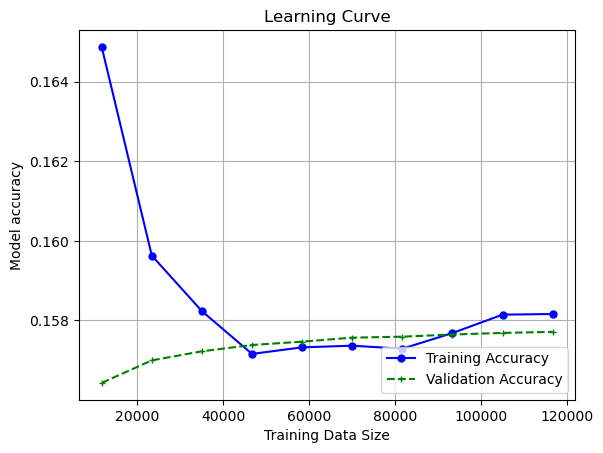

In [8]:

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=lr_model, X=x_train_scaled, y=y_train,
                                                       cv=10, train_sizes=np.linspace(0.1, 1.0, 10, 100),
                                                       n_jobs=1)
# Calculate training and test mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

Tune Hyperparameters

In [9]:
# regularization

# from scipy.stats import loguniform
# from sklearn.model_selection import RepeatedKFold
# from sklearn.model_selection import RandomizedSearchCV

# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define search space
# space = dict()
# # space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
# # space['alpha'] = loguniform(1e-5, 100)
# space['fit_intercept'] = [True, False]
# space['normalize'] = [True, False]
# # define search
# search = RandomizedSearchCV(lr_model, space, n_iter=500, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)
# # execute search
# result = search.fit(x_train_scaled, y_train)
# # summarize result
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)




In [16]:

y_predInverse = scale.inverse_transform(x_train_scaled)
# y_testInverse = scale.inverse_transform(y_test)

[[ 8.76233889  3.16335972  3.19518889 ...  5.1473     -0.63703
   0.77084   ]
 [11.89475833 12.55755556  5.12194583 ...  5.1572      0.233
   0.97248   ]
 [ 5.54885     5.19215556  5.38311528 ...  3.8219      0.13533
   0.9908    ]
 ...
 [ 9.7915375  14.26610972  7.26603194 ...  4.3161      0.71099
   0.7032    ]
 [11.79617639  4.81558194  3.0388     ... -5.3201      0.92256
  -0.38585   ]
 [ 2.74502639  3.082175    5.35197778 ... -5.333      -0.36806
   0.9298    ]]
